# Time-decay Attribution and Causal Analysis

**The problem**: Advertisers run campaigns across multiple channels (search, display, video) but struggle to know which ads actually drive sales. The standard approach, last-touch attribution (LTA), credits the final ad a customer saw before purchasing. This can systematically overcredit lower-funnel ads (search) that appear right before conversion, while undercrediting upper-funnel ads (display, video) that built awareness earlier. The result is misallocated budgets and underinvestment in channels with higher true ROI.

**Two measurement approaches**:
1. **Time Decay Attribution (TDA)**: Reallocates LTA credit by modeling ad carryover, i.e., how impressions accumulate and decay over time. If upper-funnel ads have longer carryover, they gain credit in the time-decay approach vs LTA.
2. **Causal Attribution (CA)**: Uses DoWhy to decompose YoY sales growth into ad-driven contributions. Thus we know how much each spend change contributed to business outcome. 

These two approaches together tell you both what types of ads influenced conversions beyond rule-based approaches and what drove growth.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy import optimize
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

from dowhy import gcm
from dowhy.gcm.util import plot as plot_graph
from dowhy.gcm.falsify import falsify_graph, apply_suggestions

## 1. Data Generation

**Synthetic data with 4 ad channels: SP, SB, Display, Video**:
1. SP/SB: high LTA share (75% combined), lower iROI (\$2.20-2.50), fast decay
2. Display/Video: low LTA share (25%), higher iROI (\$3.80-4.50), slow decay

In [2]:
def generate_advertising_data(start_date='2024-01-01', end_date='2025-12-31', seed=0):
    np.random.seed(seed)
    
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(dates)
    
    day_of_year = np.array([d.dayofyear for d in dates])
    year = np.array([d.year for d in dates])
    day_of_week = np.array([d.dayofweek for d in dates])
    
    # Seasonality: ±15% weekly, ±30% yearly (peaks ~June)
    weekly_pattern = 1 + 0.15 * np.sin(2 * np.pi * day_of_week / 7)
    yearly_pattern = 1 + 0.3 * np.sin(2 * np.pi * (day_of_year - 80) / 365)
    yoy_growth = np.where(year == 2025, 1.08, 1.0)  # 8% YoY growth
    
    # Events: Prime Day, Black Friday, holidays, back-to-school, Valentine's
    special_shopping_event = np.zeros(n_days)
    other_shopping_event = np.zeros(n_days)
    
    for i, d in enumerate(dates):
        if d.month == 7 and 12 <= d.day <= 14:
            special_shopping_event[i] = 1
        if d.month == 11 and 22 <= d.day <= 28:
            special_shopping_event[i] = 1
        if d.month == 12 and d.day <= 23:
            special_shopping_event[i] = 0.5
        if d.month == 8 and 15 <= d.day <= 31:
            other_shopping_event[i] = 1
        if d.month == 2 and 10 <= d.day <= 14:
            other_shopping_event[i] = 1
    
    # Spend: SP/SB track demand closely; Display/Video more stable for brand building
    base_spend_sp = 15000 * yoy_growth * weekly_pattern * yearly_pattern
    base_spend_sb = 8000 * yoy_growth * weekly_pattern * yearly_pattern
    base_spend_display = 12000 * yoy_growth * weekly_pattern * (yearly_pattern ** 0.5)
    base_spend_video = 6000 * yoy_growth * weekly_pattern * (yearly_pattern ** 0.3)
    
    event_multiplier = 1 + 0.5 * special_shopping_event + 0.2 * other_shopping_event
    
    # Noise: upper-funnel has more variance
    sp_spend = base_spend_sp * event_multiplier * (1 + 0.15 * np.random.randn(n_days))
    sb_spend = base_spend_sb * event_multiplier * (1 + 0.12 * np.random.randn(n_days))
    display_spend = base_spend_display * event_multiplier * (1 + 0.18 * np.random.randn(n_days))
    video_spend = base_spend_video * event_multiplier * (1 + 0.20 * np.random.randn(n_days))
    
    sp_spend = np.maximum(sp_spend, 100)
    sb_spend = np.maximum(sb_spend, 50)
    display_spend = np.maximum(display_spend, 100)
    video_spend = np.maximum(video_spend, 50)
    
    # Impressions via CPM: SP=$2.50, SB=$3.00, Display=$1.50, Video=$8.00
    sp_impressions = sp_spend / 2.5 * 1000
    sb_impressions = sb_spend / 3.0 * 1000
    display_impressions = display_spend / 1.5 * 1000
    video_impressions = video_spend / 8.0 * 1000
    
    # Ground truth: upper-funnel has higher iROI but gets less LTA credit
    iroi_sp, iroi_sb, iroi_display, iroi_video = 2.5, 2.2, 3.8, 4.5
    carryover_sp, carryover_sb, carryover_display, carryover_video = 0.3, 0.4, 0.7, 0.85
    lta_rate_sp, lta_rate_sb, lta_rate_display, lta_rate_video = 0.45, 0.30, 0.18, 0.07
    
    # Adstock: effective_spend[t] = spend[t] + carryover * effective_spend[t-1]
    def apply_adstock(x, carryover):
        adstocked = np.zeros_like(x)
        adstocked[0] = x[0]
        for t in range(1, len(x)):
            adstocked[t] = x[t] + carryover * adstocked[t-1]
        return adstocked
    
    sp_adstocked = apply_adstock(sp_spend, carryover_sp)
    sb_adstocked = apply_adstock(sb_spend, carryover_sb)
    display_adstocked = apply_adstock(display_spend, carryover_display)
    video_adstocked = apply_adstock(video_spend, carryover_video)
    
    # Total sales = organic + (iROI × adstocked_spend) + event_lift + noise
    organic_baseline = 80000 * yoy_growth * weekly_pattern * yearly_pattern
    incremental_from_sp = iroi_sp * sp_adstocked
    incremental_from_sb = iroi_sb * sb_adstocked
    incremental_from_display = iroi_display * display_adstocked
    incremental_from_video = iroi_video * video_adstocked
    event_lift = 30000 * special_shopping_event + 10000 * other_shopping_event
    
    total_sales = (organic_baseline + 
                   incremental_from_sp + incremental_from_sb + 
                   incremental_from_display + incremental_from_video +
                   event_lift + 5000 * np.random.randn(n_days))
    total_sales = np.maximum(total_sales, 10000)
    
    # LTA: 60% of sales are ad-touched, distributed by LTA contribution rates (independent of true iROI)
    ad_touched_sales = 0.6 * total_sales * (1 + 0.1 * np.random.randn(n_days))
    lta_sp = np.maximum(lta_rate_sp * ad_touched_sales * (1 + 0.08 * np.random.randn(n_days)), 0)
    lta_sb = np.maximum(lta_rate_sb * ad_touched_sales * (1 + 0.10 * np.random.randn(n_days)), 0)
    lta_display = np.maximum(lta_rate_display * ad_touched_sales * (1 + 0.12 * np.random.randn(n_days)), 0)
    lta_video = np.maximum(lta_rate_video * ad_touched_sales * (1 + 0.15 * np.random.randn(n_days)), 0)
    
    df = pd.DataFrame({
        'activity_date': dates,
        'year': year,
        'quarter': [d.quarter for d in dates],
        'month': [d.month for d in dates],
        'day_of_week': day_of_week,
        'sp_spend': sp_spend, 'sb_spend': sb_spend,
        'display_spend': display_spend, 'video_spend': video_spend,
        'sp_impressions': sp_impressions, 'sb_impressions': sb_impressions,
        'display_impressions': display_impressions, 'video_impressions': video_impressions,
        'special_shopping_event': special_shopping_event,
        'other_shopping_event': other_shopping_event,
        'total_sales': total_sales,
        'ad_touched_sales': ad_touched_sales,
        'lta_sales_sp': lta_sp, 'lta_sales_sb': lta_sb,
        'lta_sales_display': lta_display, 'lta_sales_video': lta_video,
    })
    
    ground_truth = {
        'iroi': {'SP': iroi_sp, 'SB': iroi_sb, 'Display': iroi_display, 'Video': iroi_video},
        'carryover': {'SP': carryover_sp, 'SB': carryover_sb, 'Display': carryover_display, 'Video': carryover_video},
        'lta_rate': {'SP': lta_rate_sp, 'SB': lta_rate_sb, 'Display': lta_rate_display, 'Video': lta_rate_video}
    }
    
    return df, ground_truth

df, ground_truth = generate_advertising_data()
print(f"Data: {len(df)} days, {df['activity_date'].min().date()} to {df['activity_date'].max().date()}")
df.head()

Data: 731 days, 2024-01-01 to 2025-12-31


,activity_date,year,quarter,month,day_of_week,sp_spend,sb_spend,display_spend,video_spend,sp_impressions,...,display_impressions,video_impressions,special_shopping_event,other_shopping_event,total_sales,ad_touched_sales,lta_sales_sp,lta_sales_sb,lta_sales_display,lta_sales_video
0,2024-01-01,2024,1,1,0,13404.441671,5099.747577,8952.575520,3858.257279,5.361777e+06,...,5.968384e+06,482282.159891,0.0,0.0,155454.198911,87939.951886,37143.728760,23460.738849,13858.642324,6293.988387
1,2024-01-02,2024,1,1,1,12573.576417,5940.908870,10486.819125,5283.133227,5.029431e+06,...,6.991213e+06,660391.653381,0.0,0.0,219463.068045,145232.875195,52965.494493,44159.286689,30375.435747,14314.282119
2,2024-01-03,2024,1,1,2,13979.535290,5680.663153,11816.388289,7530.793229,5.591814e+06,...,7.877592e+06,941349.153615,0.0,0.0,284656.682628,172537.129670,76023.283438,46311.842059,27777.802951,9154.003839
3,2024-01-04,2024,1,1,3,15161.875157,7865.616003,9500.538566,5050.795393,6.064750e+06,...,6.333692e+06,631349.424145,0.0,0.0,313792.139323,236249.947675,107409.255926,85420.610730,53827.211856,20315.500984
4,2024-01-05,2024,1,1,4,12775.945666,3888.599153,9579.377571,6822.546123,5.110378e+06,...,6.386252e+06,852818.265345,0.0,0.0,323851.281693,185840.293859,75548.541173,61245.391132,32032.104714,8354.883341


In [3]:
print("Ground Truth:")
print(f"  iROI: {ground_truth['iroi']}")
print(f"  Carryover: {ground_truth['carryover']}")
print(f"  LTA rates: {ground_truth['lta_rate']}")

Ground Truth:
  iROI: {'SP': 2.5, 'SB': 2.2, 'Display': 3.8, 'Video': 4.5}
  Carryover: {'SP': 0.3, 'SB': 0.4, 'Display': 0.7, 'Video': 0.85}
  LTA rates: {'SP': 0.45, 'SB': 0.3, 'Display': 0.18, 'Video': 0.07}


In [4]:
df_2024 = df[df['year'] == 2024]
df_2025 = df[df['year'] == 2025]

print(f"YoY Change (2025 vs 2024):")
for col in ['total_sales', 'sp_spend', 'sb_spend', 'display_spend', 'video_spend']:
    pct = (df_2025[col].mean() - df_2024[col].mean()) / df_2024[col].mean() * 100
    print(f"  {col}: {pct:+.1f}%")

YoY Change (2025 vs 2024):
  total_sales: +8.3%
  sp_spend: +5.9%
  sb_spend: +8.4%
  display_spend: +8.0%
  video_spend: +7.2%


## 2. Time Decay MTA

Reallocate LTA credit using adstock transformation. Channels with higher carryover (Display/Video) accumulate more effective impressions over time, gaining credit vs LTA.

In [5]:
def apply_adstock(series, carryover):
    """Geometric adstock: result[t] = x[t] + carryover * result[t-1]"""
    result = np.zeros_like(series, dtype=float)
    result[0] = series[0]
    for t in range(1, len(series)):
        result[t] = series[t] + carryover * result[t-1]
    return result

def build_adstocked_features(X, carryover_map):
    """Apply channel-specific carryover to build adstocked feature matrix."""
    X_adstocked = pd.DataFrame(index=X.index)
    for col in X.columns:
        carry = carryover_map.get(col, 0.5)
        X_adstocked[col] = apply_adstock(X[col].values, carry)
    return X_adstocked

def time_decay_attribution(X_adstocked, y, lam=10.0):
    """Ridge regression on adstocked features, rescaled to sum to total LTA."""
    X_arr = X_adstocked.values
    X_mean = X_arr.mean(axis=0)
    X_std = X_arr.std(axis=0) + 1e-8
    X_scaled = (X_arr - X_mean) / X_std
    
    model = Ridge(alpha=lam, fit_intercept=True)
    model.fit(X_scaled, y.values)
    coefs = model.coef_ / X_std
    y_pred = model.predict(X_scaled)
    
    contributions = {}
    for i, col in enumerate(X_adstocked.columns):
        contrib = coefs[i] * X_adstocked[col].values
        contributions[col] = np.maximum(contrib, 0).sum()
    
    total_contrib = sum(contributions.values())
    if total_contrib > 0:
        scale = y.sum() / total_contrib
        contributions = {k: v * scale for k, v in contributions.items()}
    
    return contributions, model, y_pred

def cv_objective(params, X, y, channels, carryover_bounds, lambda_bounds, n_splits=5):
    """Cross-validation objective: validation MAE + overfitting penalty + regularization on carryover."""
    n_channels = len(channels)
    carryover_map = {channels[i]: params[i] for i in range(n_channels)}
    lam = params[n_channels]
    
    # Boundary check
    for carry in carryover_map.values():
        if carry < carryover_bounds[0] or carry > carryover_bounds[1]:
            return 1e10
    if lam < lambda_bounds[0] or lam > lambda_bounds[1]:
        return 1e10
    
    X_adstocked = build_adstocked_features(X, carryover_map)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    train_maes, val_maes = [], []
    
    for train_idx, val_idx in tscv.split(X_adstocked):
        X_train, X_val = X_adstocked.iloc[train_idx], X_adstocked.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Standardize using train stats only
        X_train_arr = X_train.values
        X_mean = X_train_arr.mean(axis=0)
        X_std = X_train_arr.std(axis=0) + 1e-8
        X_train_scaled = (X_train_arr - X_mean) / X_std
        
        model = Ridge(alpha=lam, fit_intercept=True)
        model.fit(X_train_scaled, y_train.values)
        
        y_train_pred = model.predict(X_train_scaled)
        X_val_scaled = (X_val.values - X_mean) / X_std
        y_val_pred = model.predict(X_val_scaled)
        
        train_maes.append(mean_absolute_error(y_train, y_train_pred))
        val_maes.append(mean_absolute_error(y_val, y_val_pred))
    
    train_mae = np.mean(train_maes)
    val_mae = np.mean(val_maes)
    gap_penalty = max(0, val_mae - train_mae) / (train_mae + 1e-8)
    carryover_penalty = sum(c**2 for c in carryover_map.values()) / n_channels
    
    return val_mae + 0.1 * gap_penalty * val_mae + 0.05 * carryover_penalty * val_mae

def optimize_carryover(X, y, channels, carryover_bounds=(0.1, 0.95), lambda_bounds=(1, 100), maxiter=50):
    """Find optimal carryover rates via differential evolution."""
    n_channels = len(channels)
    bounds = [carryover_bounds] * n_channels + [lambda_bounds]
    
    result = optimize.differential_evolution(
        cv_objective,
        bounds=bounds,
        args=(X, y, channels, carryover_bounds, lambda_bounds),
        seed=0,
        maxiter=maxiter,
        tol=1e-6,
        disp=False,
        workers=1
    )
    
    carryover_map = {channels[i]: result.x[i] for i in range(n_channels)}
    lam_opt = result.x[n_channels]
    
    return carryover_map, lam_opt

In [6]:
channels = ['SP', 'SB', 'Display', 'Video']
X_impressions = df.set_index('activity_date')[['sp_impressions', 'sb_impressions', 'display_impressions', 'video_impressions']].copy()
X_impressions.columns = channels
y_lta_total = df.set_index('activity_date')[['lta_sales_sp', 'lta_sales_sb', 'lta_sales_display', 'lta_sales_video']].sum(axis=1)

print(f"X: {X_impressions.shape}, y: {y_lta_total.shape}")

X: (731, 4), y: (731,)


In [7]:
carryover_opt, lam_opt = optimize_carryover(
    X_impressions, y_lta_total, channels,
    carryover_bounds=(0.1, 0.95),
    lambda_bounds=(5, 100),
    maxiter=50
)

print("Optimized carryover rates:")
for ch, carry in carryover_opt.items():
    half_life = np.log(0.5) / np.log(carry) if carry > 0 else 0
    true_carry = ground_truth['carryover'].get(ch, 'N/A')
    print(f"  {ch}: {carry:.3f} (half-life: {half_life:.1f}d) | actual: {true_carry}")
print(f"Lambda: {lam_opt:.2f}")

Optimized carryover rates:
  SP: 0.100 (half-life: 0.3d) | actual: 0.3
  SB: 0.676 (half-life: 1.8d) | actual: 0.4
  Display: 0.100 (half-life: 0.3d) | actual: 0.7
  Video: 0.823 (half-life: 3.6d) | actual: 0.85
Lambda: 13.49


In [8]:
X_adstocked = build_adstocked_features(X_impressions, carryover_opt)
mta_contrib, _, _ = time_decay_attribution(X_adstocked, y_lta_total, lam_opt)

lta_totals = {
    'SP': df['lta_sales_sp'].sum(),
    'SB': df['lta_sales_sb'].sum(),
    'Display': df['lta_sales_display'].sum(),
    'Video': df['lta_sales_video'].sum()
}

total_lta = sum(lta_totals.values())
total_mta = sum(mta_contrib.values())

In [9]:
print("LTA vs MTA Attribution:")
print(f"{'Channel':<10} {'LTA ($M)':<12} {'LTA %':<10} {'MTA ($M)':<12} {'MTA %':<10} {'Shift':<10}")
print("-" * 64)
for ch in channels:
    lta_val = lta_totals[ch] / 1e6
    lta_pct = lta_totals[ch] / total_lta * 100
    mta_val = mta_contrib[ch] / 1e6
    mta_pct = mta_contrib[ch] / total_mta * 100
    shift = mta_pct - lta_pct
    print(f"{ch:<10} {lta_val:<12.1f} {lta_pct:<10.1f} {mta_val:<12.1f} {mta_pct:<10.1f} {shift:+.1f}pp")

LTA vs MTA Attribution:
Channel    LTA ($M)     LTA %      MTA ($M)     MTA %      Shift     
----------------------------------------------------------------
SP         103.9        45.1       22.0         9.5        -35.5pp
SB         69.3         30.0       68.1         29.5       -0.5pp
Display    41.3         17.9       30.4         13.2       -4.8pp
Video      16.1         7.0        110.2        47.8       +40.8pp


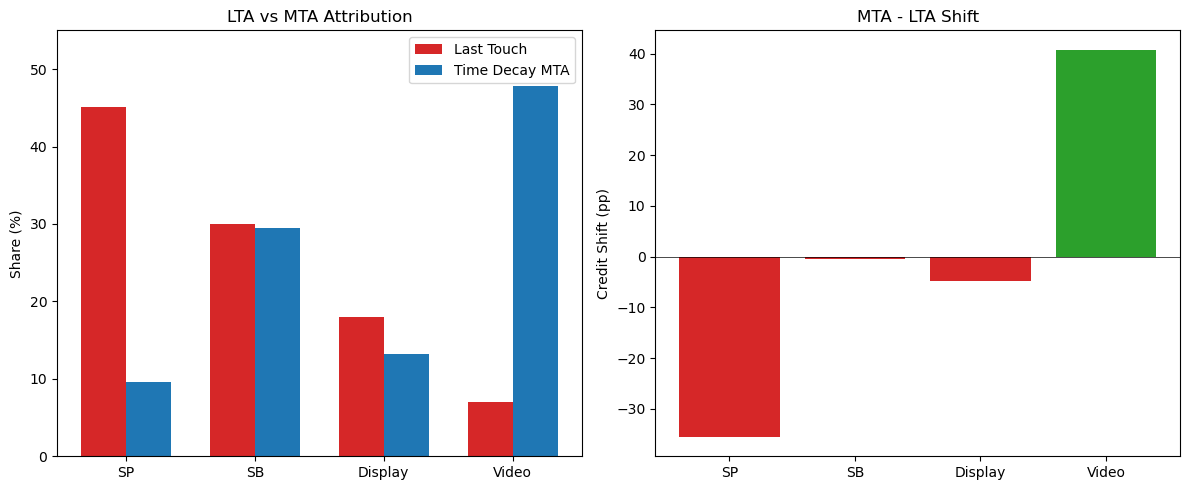

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(channels))
width = 0.35

ax1 = axes[0]
lta_pcts = [lta_totals[c]/total_lta*100 for c in channels]
mta_pcts = [mta_contrib[c]/total_mta*100 for c in channels]
ax1.bar(x - width/2, lta_pcts, width, label='Last Touch', color='tab:red')
ax1.bar(x + width/2, mta_pcts, width, label='Time Decay MTA', color='tab:blue')
ax1.set_xticks(x)
ax1.set_xticklabels(channels)
ax1.set_ylabel('Share (%)')
ax1.set_title('LTA vs MTA Attribution')
ax1.legend()
ax1.set_ylim(0, 55)

ax2 = axes[1]
shifts = [mta_pcts[i] - lta_pcts[i] for i in range(len(channels))]
colors = ['tab:green' if s > 0 else 'tab:red' for s in shifts]
ax2.bar(channels, shifts, color=colors)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_ylabel('Credit Shift (pp)')
ax2.set_title('MTA - LTA Shift')

plt.tight_layout()
plt.show()

## 3. Causal Incrementality (DoWhy)

Decompose YoY sales growth into driver contributions using DoWhy GCM:
1. Build DAG: spend variables, other drivers → sale
2. Fit causal model
3. Attribute mean change via Shapley values

### 3.1 With Raw Spend

This is the default approach by fitting the model directly on observed spend without any time-series transformation.

In [11]:
df_causal = df[['activity_date', 'year', 'quarter',
                'sp_spend', 'sb_spend', 'display_spend', 'video_spend',
                'special_shopping_event', 'other_shopping_event',
                'total_sales']].copy()
df_causal.columns = ['activity_date', 'year', 'quarter',
                     'sp_spend', 'sb_spend', 'display_spend', 'video_spend',
                     'special_shopping_event', 'other_shopping_event', 'sale']

print(f"Causal data: {len(df_causal)} rows")

Causal data: 731 rows


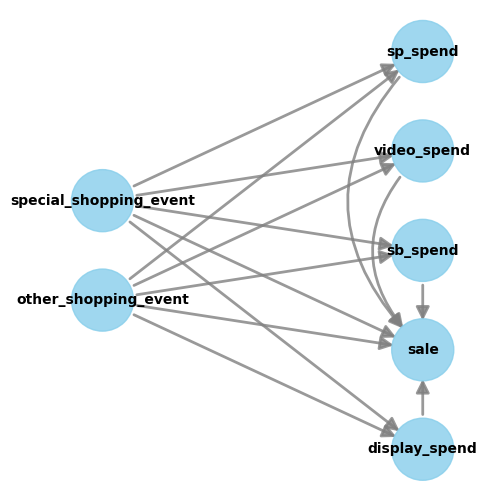

In [12]:
edges = []
for col in ['sp_spend', 'sb_spend', 'display_spend', 'video_spend']:
    edges.append((col, 'sale'))
edges.append(('special_shopping_event', 'sale'))
edges.append(('other_shopping_event', 'sale'))

# Events → spend (confounding path)
for col in ['sp_spend', 'sb_spend', 'display_spend', 'video_spend']:
    edges.append(('special_shopping_event', col))
    edges.append(('other_shopping_event', col))
    
causal_graph = nx.DiGraph(edges)
plot_graph(causal_graph)

In [13]:
# Graph validation (optional for simple DAGs; useful for complex graphs)
RUN_GRAPH_VALIDATION = True

if RUN_GRAPH_VALIDATION:
    validation_data = df_causal[['sp_spend','sb_spend','display_spend','video_spend',
                                  'special_shopping_event','other_shopping_event','sale']]
    result = falsify_graph(causal_graph, validation_data, suggestions=True, n_permutations=20)
    print(result)
    # Apply suggestions to get revised graph
    causal_graph = apply_suggestions(causal_graph, result)
    print(f"\nRevised graph edges: {list(causal_graph.edges())}")
else:
    print("Graph validation skipped")

Test permutations of given graph: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]

+-------------------------------------------------------------------------------------------------------+
|                                         Falsification Summary                                         |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 14/14 LMCs and is better than 0.0% of the permuted DAGs (p-value: 1.00).       |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we reject the DAG.                                                                                    |
+-------------------------------------------------------------------------------------------------------+
|                                             

In [14]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, df_causal, quality=gcm.auto.AssignmentQuality.BETTER)
gcm.fit(causal_model, df_causal)

Fitting causal mechanism of node other_shopping_event: 100%|██████████| 7/7 [00:00<00:00, 57.55it/s]  


In [15]:
# Define growth period for comparison 

df_new = df_causal[(df_causal['year'] == 2025) & (df_causal['quarter'].isin([1, 2]))].copy()
df_old = df_causal[(df_causal['year'] == 2024) & (df_causal['quarter'].isin([1, 2]))].copy()

mean_old = df_old['sale'].mean()
mean_new = df_new['sale'].mean()
total_change = mean_new - mean_old

print(f"Comparing: 2025 H1 ({len(df_new)}d) vs 2024 H1 ({len(df_old)}d)")
print(f"Mean daily sales: 2024=${mean_old:,.0f}, 2025=${mean_new:,.0f}")
print(f"Daily change: ${total_change:,.0f}")

Comparing: 2025 H1 (181d) vs 2024 H1 (182d)
Mean daily sales: 2024=$496,566, 2025=$540,356
Daily change: $43,790


In [16]:
# Decompose mean change via Shapley values
# Can swap np.mean for np.median or np.var to decompose those instead

median_contribs, uncertainty = gcm.confidence_intervals(
    lambda: gcm.distribution_change(
        causal_model, df_old, df_new, 'sale',
        num_samples=2000,
        difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x)
    ),
    confidence_level=0.95,
    num_bootstrap_resamples=20
)

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:53<00:00,  2.70s/it]


In [17]:
growth_rate = (mean_new - mean_old) / mean_old * 100

print("Causal Attribution to YoY Sales Change:")
print(f"{'Driver':<20} {'Contrib $':<12} {'% of Total':<12} {'% of Growth':<12} {'iROAS':<10} {'95% CI':<22}")
print("-" * 98)

sum_contribs = 0
total_abs_contrib = sum(abs(v) for v in median_contribs.values())

spend_changes = {}
for col in ['sp_spend', 'sb_spend', 'display_spend', 'video_spend']:
    spend_changes[col] = df_new[col].mean() - df_old[col].mean()

for node in sorted(median_contribs.keys(), key=lambda x: -abs(median_contribs[x])):
    val = median_contribs[node]
    sum_contribs += val
    pct_total = (val / total_abs_contrib * 100) if total_abs_contrib > 0 else 0
    pct_growth = (val / mean_old * 100)
    lb, ub = uncertainty[node]
    sig = "*" if (lb > 0 or ub < 0) else ""
    
    if node in spend_changes:
        spend_chg = spend_changes[node]
        iroas = val / spend_chg if spend_chg != 0 else 0
        print(f"{node:<20} ${val:>10,.0f} {pct_total:>10.1f}%  {pct_growth:>10.2f}%    ${iroas:>7.2f} {sig:<2} [{lb:>8,.0f}, {ub:>8,.0f}]")
    else:
        print(f"{node:<20} ${val:>10,.0f} {pct_total:>10.1f}%  {pct_growth:>10.2f}%    {'N/A':>8} {sig:<2} [{lb:>8,.0f}, {ub:>8,.0f}]")

print("-" * 98)
print(f"{'Sum of contributions':<20} ${sum_contribs:>10,.0f} {'':>11} {sum_contribs/mean_old*100:>10.2f}%")
print(f"{'Actual mean change':<20} ${total_change:>10,.0f} {'':>11} {growth_rate:>10.2f}%")

print(f"\nKPI summary (daily sales):")
print(f"  2024 H1: mean=${mean_old:,.0f}, median=${df_old['sale'].median():,.0f}")
print(f"  2025 H1: mean=${mean_new:,.0f}, median=${df_new['sale'].median():,.0f}")
print(f"  YoY growth: {growth_rate:.2f}% (mean)")

print(f"\n* = CI excludes 0")
print(f"% of Growth = contribution / baseline mean")
print(f"iROAS = sales contribution / spend change")
print(f"'sale' row = unexplained variance (organic growth, noise)")
print(f"Note: Sum ≠ actual due to Monte Carlo sampling in Shapley estimation. Increase num_samples/num_bootstrap_resamples to reduce gap.")

Causal Attribution to YoY Sales Change:
Driver               Contrib $    % of Total   % of Growth  iROAS      95% CI                
--------------------------------------------------------------------------------------------------
sale                 $    20,145       51.0%        4.06%         N/A *  [  19,026,   21,371]
sb_spend             $    13,977       35.4%        2.81%    $  15.96 *  [  12,936,   14,784]
display_spend        $     3,630        9.2%        0.73%    $   4.13 *  [   2,803,    4,301]
video_spend          $     1,347        3.4%        0.27%    $   2.96 *  [     618,    1,849]
sp_spend             $      -287       -0.7%       -0.06%    $  -0.38    [    -942,      843]
other_shopping_event $        60        0.2%        0.01%         N/A    [    -752,      733]
special_shopping_event $        34        0.1%        0.01%         N/A    [    -971,      968]
--------------------------------------------------------------------------------------------------
Sum of c

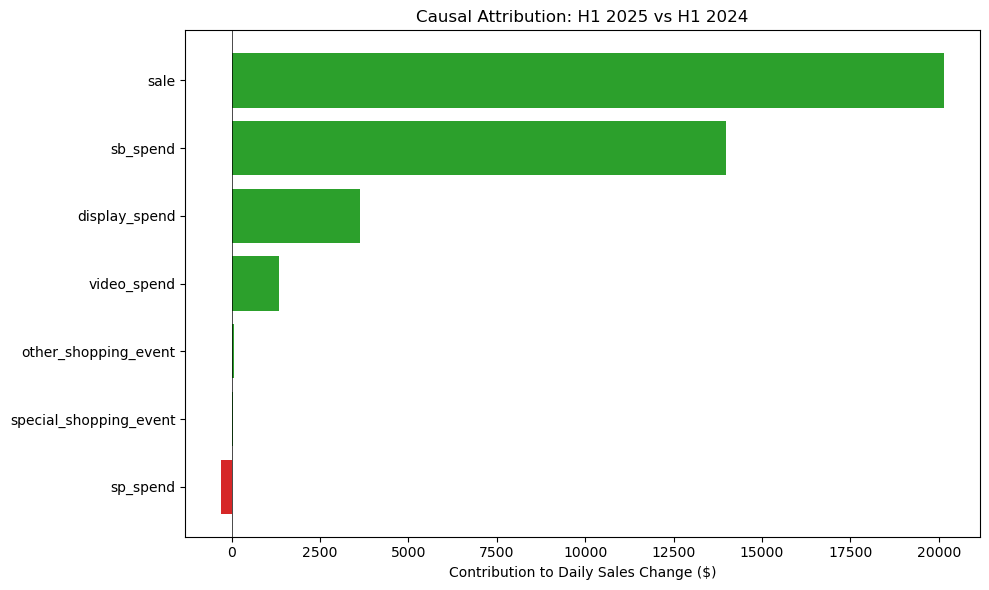

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

drivers = list(median_contribs.keys())
contribs = [median_contribs[d] for d in drivers]
sorted_idx = np.argsort(contribs)[::-1]
drivers = [drivers[i] for i in sorted_idx]
contribs = [contribs[i] for i in sorted_idx]

colors = ['tab:green' if c > 0 else 'tab:red' for c in contribs]
ax.barh(drivers, contribs, color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Contribution to Daily Sales Change ($)')
ax.set_title('Causal Attribution: H1 2025 vs H1 2024')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [19]:
print("iROI Estimation (via intervention):")
print(f"{'Channel':<15} {'Est. iROI':<15} {'Actual iROI':<15}")
print("-" * 45)

for spend_var, ch in [('sp_spend', 'SP'), ('sb_spend', 'SB'), 
                       ('display_spend', 'Display'), ('video_spend', 'Video')]:
    step = 1000
    effect = gcm.average_causal_effect(
        causal_model=causal_model,
        target_node='sale',
        interventions_alternative={spend_var: lambda x, s=step: x + s},
        interventions_reference={spend_var: lambda x: x},
        num_samples_to_draw=3000
    )
    iroi = effect / step
    actual_iroi = ground_truth['iroi'][ch]
    print(f"{ch:<15} ${iroi:<14.2f} ${actual_iroi:<14.2f}")

iROI Estimation (via intervention):
Channel         Est. iROI       Actual iROI    
---------------------------------------------
SP              $7.35           $2.50          
SB              $12.63          $2.20          
Display         $5.07           $3.80          
Video           $5.25           $4.50          


The iROI estimates differ from ground truth. Possible reasons:
- DAG uses raw spend, but DGP applies adstock before computing sales
- Auto-assigned mechanism may not capture the adstock transform
- Unmeasured confounders (competitor activity, macro factors, etc.)

### 3.2 With Adstocked Spend

Section 3.1 used raw spend as inputs, but our DGP generates sales from adstocked spend, where each day's effect accumulates from prior days' spending. This mismatch could explain the iROI gaps above.

To test this, we transform spend using ground truth carryover rates and refit:

In [20]:
# Create adstocked spend columns using ground truth carryover rates
def apply_adstock(x, carryover):
    adstocked = np.zeros_like(x)
    adstocked[0] = x[0]
    for t in range(1, len(x)):
        adstocked[t] = x[t] + carryover * adstocked[t-1]
    return adstocked

df_causal_adstocked = df_causal.copy()
df_causal_adstocked['sp_spend'] = apply_adstock(df_causal['sp_spend'].values, 0.3)
df_causal_adstocked['sb_spend'] = apply_adstock(df_causal['sb_spend'].values, 0.4)
df_causal_adstocked['display_spend'] = apply_adstock(df_causal['display_spend'].values, 0.7)
df_causal_adstocked['video_spend'] = apply_adstock(df_causal['video_spend'].values, 0.85)

# Rebuild causal model with adstocked data
causal_model_adstocked = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model_adstocked, df_causal_adstocked, quality=gcm.auto.AssignmentQuality.BETTER)
gcm.fit(causal_model_adstocked, df_causal_adstocked)

# Test iROI
print("iROI with adstocked spend:")
print(f"{'Channel':<15} {'Est. iROI':<15} {'Actual iROI':<15}")
print("-" * 45)

for spend_var, ch in [('sp_spend', 'SP'), ('sb_spend', 'SB'), 
                       ('display_spend', 'Display'), ('video_spend', 'Video')]:
    step = 1000
    effect = gcm.average_causal_effect(
        causal_model=causal_model_adstocked,
        target_node='sale',
        interventions_alternative={spend_var: lambda x, s=step: x + s},
        interventions_reference={spend_var: lambda x: x},
        num_samples_to_draw=3000
    )
    iroi = effect / step
    actual_iroi = ground_truth['iroi'][ch]
    print(f"{ch:<15} ${iroi:<14.2f} ${actual_iroi:<14.2f}")

Fitting causal mechanism of node other_shopping_event: 100%|██████████| 7/7 [00:00<00:00, 59.47it/s]  

iROI with adstocked spend:
Channel         Est. iROI       Actual iROI    
---------------------------------------------
SP              $2.45           $2.50          
SB              $4.73           $2.20          
Display         $4.18           $3.80          
Video           $4.53           $4.50          


SP and SB improved drastically because these channels have correlated spend in the DGP, with both following demand seasonality and spike during events. We generated data that way to mimic real-world investment preferences.

When inputs are highly correlated, the model struggles to separate individual effects (that's why SB showed >$10 before because it was absorbing variance from other channels). Different carryover rates (0.3 vs 0.4) transform each channel differently, reducing correlation and letting the model distinguish their contributions.

In contrast, Display and Video were already close because their spend is more stable and less correlated with other channels (dampened seasonality in DGP). The model already works reasonably well without the transform.

Real data doesn't come with known carryover rates, so this is more of a sanity check on the DGP than a practical approach.

## 4. Summary

For reporting: LTA reflects what most attribution systems currently credits, MTA shows what credit would look like with carryover modeled, and causal attribution estimates actual business impact. When presenting to stakeholders, you can show all three to highlight the gap between LTA and MTA/causal highlights where budget reallocation opportunities exist.

In [22]:
print("=" * 70)
print("Summary: LTA vs MTA vs Incrementality")
print("=" * 70)
print(f"{'Channel':<10} {'LTA %':<12} {'MTA %':<12} {'Shift':<12} {'Actual iROI':<12}")
print("-" * 58)

for ch in channels:
    lta_pct = lta_totals[ch] / total_lta * 100
    mta_pct = mta_contrib[ch] / total_mta * 100
    shift = mta_pct - lta_pct
    iroi = ground_truth['iroi'][ch]
    print(f"{ch:<10} {lta_pct:<12.1f} {mta_pct:<12.1f} {shift:+11.1f}pp ${iroi:<11.2f}")

print("-" * 58)
print(f"\nSP+SB LTA share: {(lta_totals['SP']+lta_totals['SB'])/total_lta*100:.0f}%")
print(f"SP+SB MTA share: {(mta_contrib['SP']+mta_contrib['SB'])/total_mta*100:.0f}%")
print(f"Display+Video gain: {(mta_contrib['Display']+mta_contrib['Video'])/total_mta*100 - (lta_totals['Display']+lta_totals['Video'])/total_lta*100:+.0f}pp")

Summary: LTA vs MTA vs Incrementality
Channel    LTA %        MTA %        Shift        Actual iROI 
----------------------------------------------------------
SP         45.1         9.5                -35.5pp $2.50       
SB         30.0         29.5                -0.5pp $2.20       
Display    17.9         13.2                -4.8pp $3.80       
Video      7.0          47.8               +40.8pp $4.50       
----------------------------------------------------------

SP+SB LTA share: 75%
SP+SB MTA share: 39%
Display+Video gain: +36pp
